# Reading data from CSV file and Annotating Continuous Data

# Loading CSV file
    - Use pd.read_csv function to load data
    - Call transpose since mne expects channels to be formatted as rows
    - set sample frequency 
    - set meas_date date to 0 to avoid Ambiguous operation error

## Plotting Events `events.txt`
    - First column measures sample, second column is place holder, third column is label

## Plotting Annotations
    - First column is onset, seconds column is duration, third column is label
    - [Events](https://mne.tools/stable/glossary.html#term-events)
    - [read_events()](https://mne.tools/stable/generated/mne.read_events.html#mne-read-events)
    - [Work around for `RuntimeError: Ambiguous operation` (read_annotations) -> raw.set_meas_date(0) ](https://github.com/mne-tools/mne-python/issues/5908#issuecomment-461865564)
    - [Read Annotations](https://mne.tools/stable/generated/mne.read_annotations.html#mne-read-annotations)

# Tutorials
- [Time Frequency Analysis Example](https://mne.tools/stable/auto_examples/time_frequency/time_frequency_simulated.html#)
- [Creating epochs from raw data](https://mne.tools/stable/auto_tutorials/epochs/10_epochs_overview.html#creating-epoched-data-from-a-raw-object)
- [Frequency and time-frequency sensor analysis](https://mne.tools/stable/auto_tutorials/time-freq/20_sensors_time_frequency.html#sphx-glr-auto-tutorials-time-freq-20-sensors-time-frequency-py)

# MNE API
- [MNE epochs](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs)

# Additional Resources
- [https://fooof-tools.github.io/fooof/auto_examples/analyses/plot_mne_example.html](https://fooof-tools.github.io/fooof/auto_examples/analyses/plot_mne_example.html)
- [https://notebook.community/mne-tools/mne-tools.github.io/0.14/_downloads/plot_objects_from_arrays](https://notebook.community/mne-tools/mne-tools.github.io/0.14/_downloads/plot_objects_from_arrays)
- [https://mne.discourse.group/](https://mne.discourse.group/)
- [https://natmeg.se/mne_timefrequency/MNE_timefrequency.html](https://natmeg.se/mne_timefrequency/MNE_timefrequency.html)
- [https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html](https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html)(multiplot example)

- [Intrepreting EEG Spectrograms](https://connect.springerpub.com/content/book/978-0-8261-9355-1/part/part01/chapter/ch01)



# Preprocessing

We adopt the following preprocessing steps discussed by [Makoto](https://sccn.ucsd.edu/wiki/Makoto's_preprocessing_pipeline#High-pass_filter_the_data_at_1-Hz_.28for_ICA.2C_ASR.2C_and_CleanLine.29.2805.2F18.2F2022_updated.29)


1. [Down sample if necessary](https://sccn.ucsd.edu/wiki/Makoto's_preprocessing_pipeline#Downsample_if_necessary)
2. [High pass filter at 1hz (if ICA is going to be done)](https://sccn.ucsd.edu/wiki/Makoto's_preprocessing_pipeline#High-pass_filter_the_data_at_1-Hz_.28for_ICA.2C_ASR.2C_and_CleanLine.29.2805.2F18.2F2022_updated.29)
3. Import channel information
4. Remove bad channels
5. [Interpolate removed channels](https://sccn.ucsd.edu/wiki/Makoto's_preprocessing_pipeline#Interpolate_all_the_removed_channels_.2806.2F14.2F2021_updated.29)
6. [Re-Reference data to average](https://sccn.ucsd.edu/wiki/Makoto's_preprocessing_pipeline#Re-reference_the_data_to_average_.2808.2F02.2F2020_Updated.29)
7. [Remove line noise](https://sccn.ucsd.edu/wiki/Makoto's_preprocessing_pipeline#Remove_line_noise_using_CleanLine_.2804.2F25.2F2020_updated.29)
8. [Epoch data to -1 to 2s](https://sccn.ucsd.edu/wiki/Makoto's_preprocessing_pipeline#Epoch_data_to_-1_to_2_sec_.2809.2F11.2F2019_updated.29)
9. [Reject epochs](https://sccn.ucsd.edu/wiki/Makoto's_preprocessing_pipeline#Reject_epochs_for_cleaning_.2811.2F13.2F2019_Updated.29)
10. [Run ICA](https://sccn.ucsd.edu/wiki/Makoto's_preprocessing_pipeline#Run_ICA)


Note some devices such as [neurosity Crown's](https://docs.neurosity.co/docs/api/brainwaves) pre-filters the data]. 

In [33]:
import torch
import pandas as pd 
import mne
import numpy as np
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_morlet
import math

def csvToRaw(file, channels):
    data = pd.read_csv('eyes_open.csv', usecols = [i+1 for i in range(channels)]).transpose()
    sfreq = 256

    # import channel info
    ch_names = ['CP3', 'C3', 'F5',  'PO3', 'PO4', 'F6', 'C4',  'CP4' ] 
    ch_types = ['eeg', 'eeg', 'eeg', 'eeg', "eeg", "eeg", "eeg", "eeg"]
    info = mne.create_info(ch_names = ch_names, sfreq = sfreq, ch_types=ch_types )
    raw = mne.io.RawArray(data, info)

    # High pass at 1hz
    raw_highpass = raw.copy().filter(l_freq=1.0, h_freq=None) 

    # Convert from uV to V for MNE
    raw_highpass.apply_function(lambda x: x * 1e-6)
    raw.apply_function(lambda x: x * 1e-6)

    # Format data date for annotations later
    raw_highpass.set_meas_date(0)
    raw_highpass.set_montage("standard_1020")

    # Re-reference the data to average
    eeg_reref_highpass, _ = mne.io.set_eeg_reference(raw_highpass) 

    return eeg_reref_highpass, raw

def getEpochs(raw, events, event_dict, tmin=-0.3, tmax=0.7):
    epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, event_id=event_dict)
    return epochs

def visualizeSpectrum(event_dict, eventTitle, epochs):
    print(f"------{eventTitle}------")
    epochs.plot()
    spectrum = epochs.compute_psd()
    spectrum.plot()
    spectrum.plot(average=True)
    spectrum.plot_topomap() # spatial distributions of the PSD, averaged across epochs and frequency bands

def visualizePower(minFreq, maxFreq, epochs, plotChannels=True, plotTopo=True, event=""):
    freqs = np.logspace(*np.log10([minFreq, maxFreq]), num=128)
    # freqs = np.arange(1, 32, 0.25)
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=True, decim=3, n_jobs=None)
   
    if plotChannels:
        for i in range(len(power.ch_names)):
            power.plot([i], baseline=(-0.5, 0), mode='logratio', title=power.ch_names[i])


    topomap_kw = dict(ch_type='eeg', tmin=0, tmax=1.0, mode='logratio', show=False)
    plot_dict = dict(Delta=dict(fmin=0, fmax=4), Alpha=dict(fmin=7, fmax=12), Beta=dict(fmin=13, fmax=25))
    
    if plotTopo:
        power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power')
        fig, axes = plt.subplots(1, 3, figsize=(10, 7))
        for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
            power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
            ax.set_title(event + " " + title)
    
        fig.tight_layout()
        fig.show()

def plotContinuousSpectorgram(file, events, event_id, channels=8, start=1, length=1, freqMin=1, freqMax = 32):
    reref, raw  = csvToRaw(file, channels)
    #reref.plot()
    power = reref.compute_psd()
    # power.plot_topomap()
    # .plot()
    end_time = math.floor(len(reref.times) / reref.info['sfreq'])
    epochs = mne.Epochs(reref, events, tmin=0, tmax=length, event_id=event_id, baseline=(0, 0))
    epochs.plot()
    epochs_power = epochs.compute_psd()
    epochs_power.plot(average=True)
    visualizePower(freqMin, freqMax, epochs, True, True, "Eyes Closed")
    
    

# Plot custom events
# events = mne.read_events("events.txt") 
# raw.plot(events=events)
# Plot custom Annotations
# annot_from_file = mne.read_annotations('saved-annotations2.csv')
# raw.set_annotations(annot_from_file)
# raw.plot()
# raw = raw.copy().crop(tmin=1, tmax=4)
# mne.viz.plot_raw(raw, events = events, n_channels=8, scalings="auto", clipping=None, start=0, duration=10.0)
# worked after doing pip install mne and opening basic python file and running python mne.py (test file)

Creating RawArray with float64 data, n_channels=8, n_times=2368
    Range : 0 ... 2367 =      0.000 ...     9.246 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Effective window size : 1.000 (s)
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 257 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 1 events and 257 original time p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


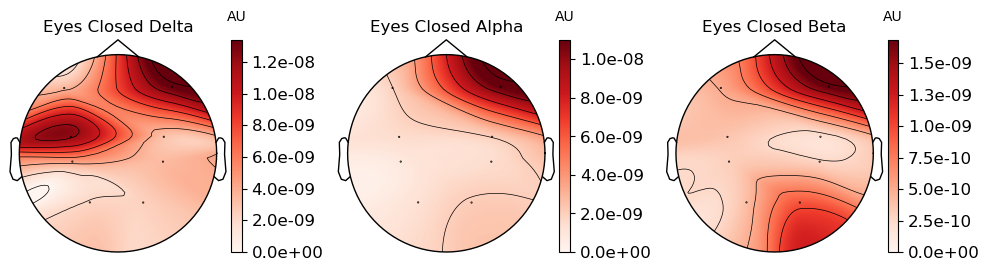

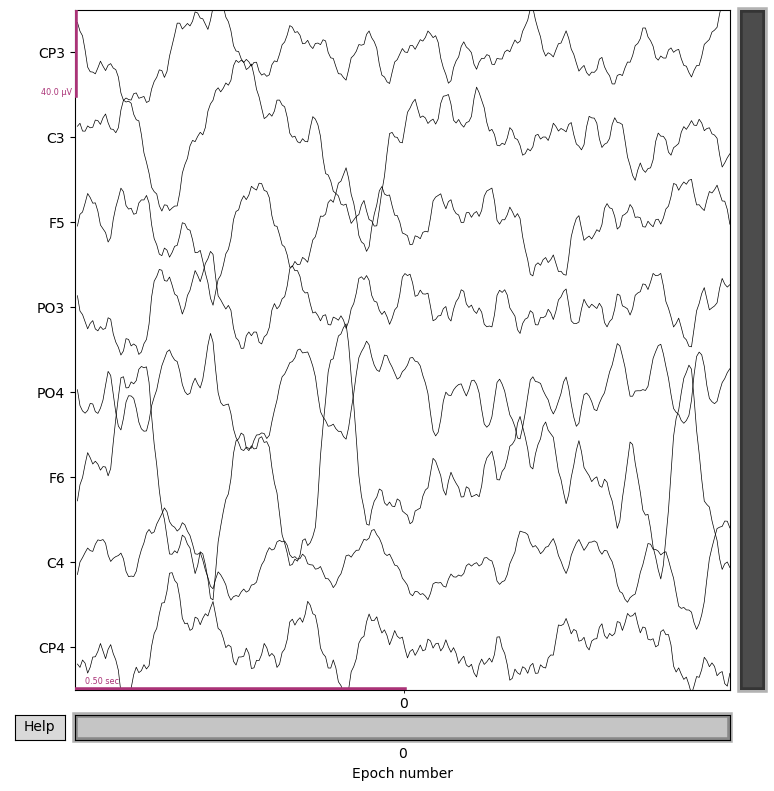

Using data from preloaded Raw for 1 events and 257 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Using data from preloaded Raw for 1 events and 257 original time points ...
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


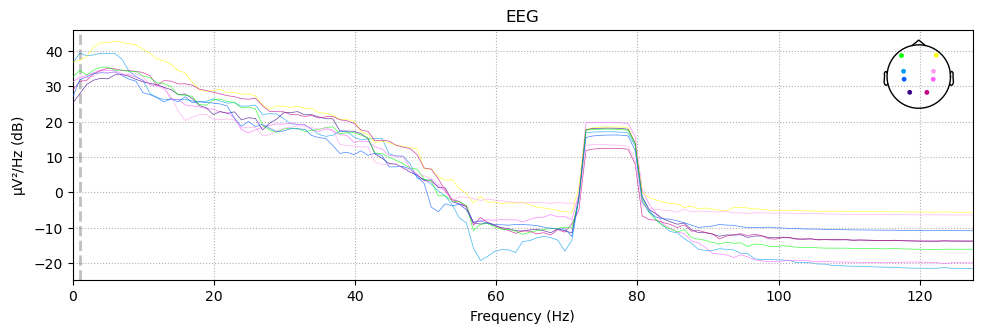

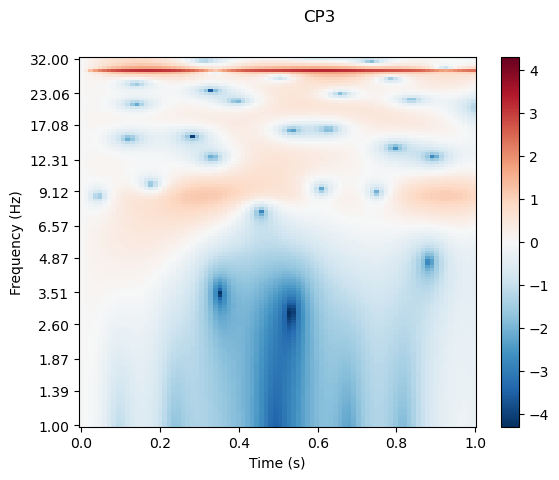

Applying baseline correction (mode: logratio)


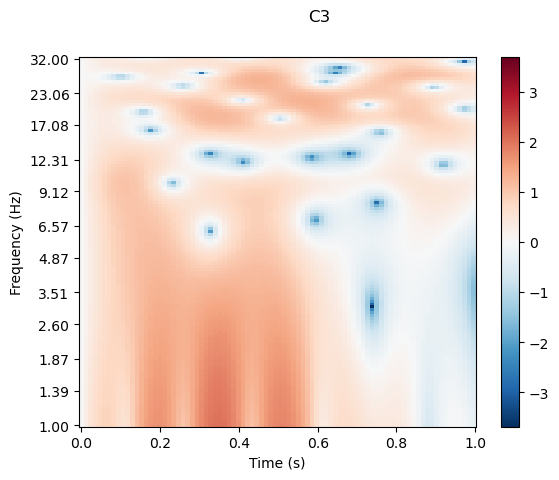

Applying baseline correction (mode: logratio)


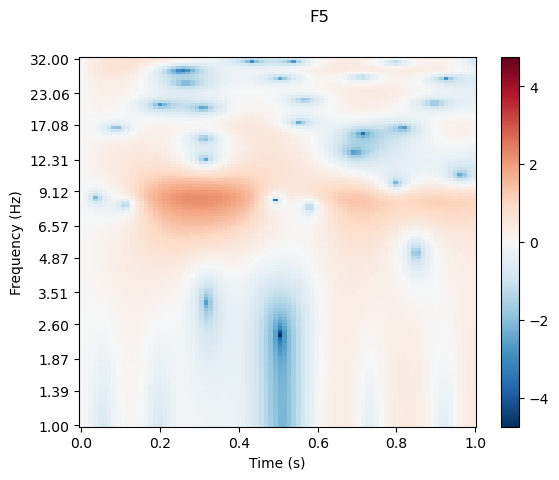

Applying baseline correction (mode: logratio)


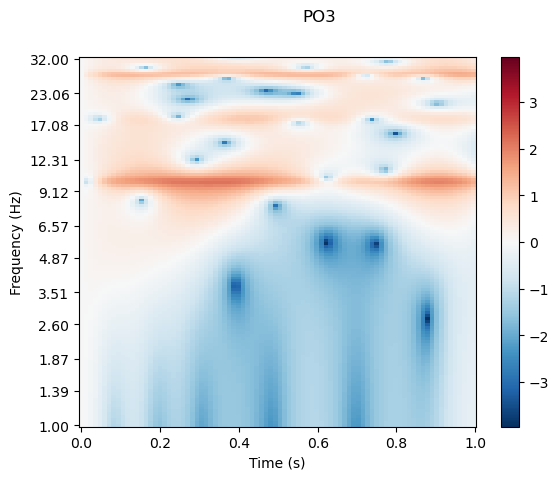

Applying baseline correction (mode: logratio)


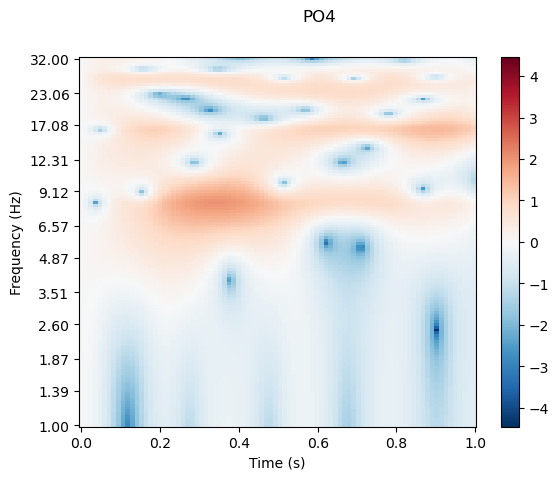

Applying baseline correction (mode: logratio)


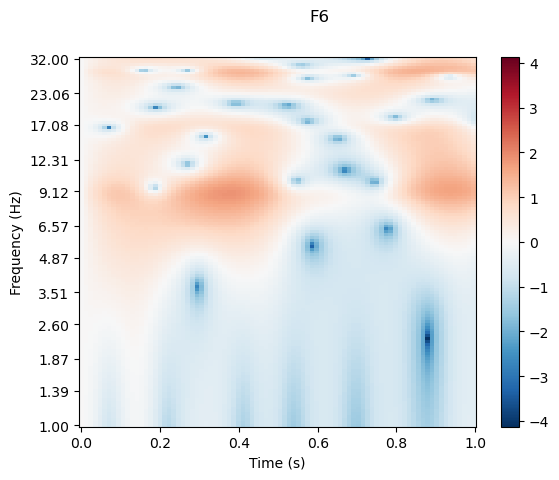

Applying baseline correction (mode: logratio)


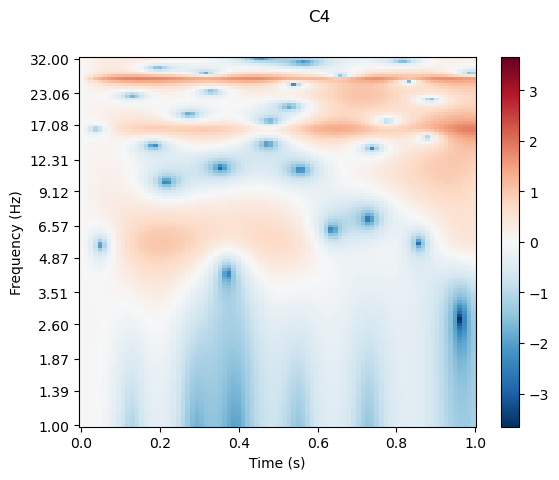

Applying baseline correction (mode: logratio)


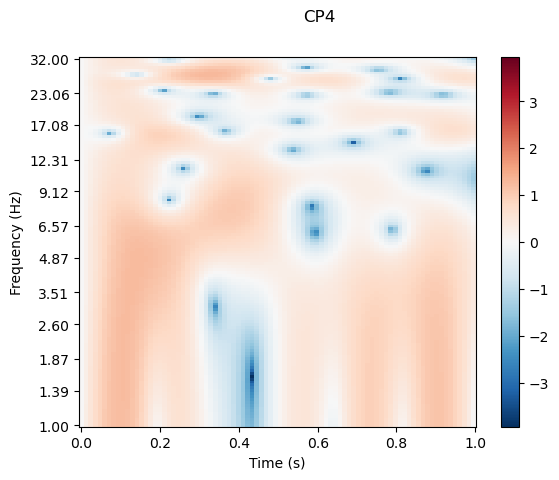

Applying baseline correction (mode: logratio)


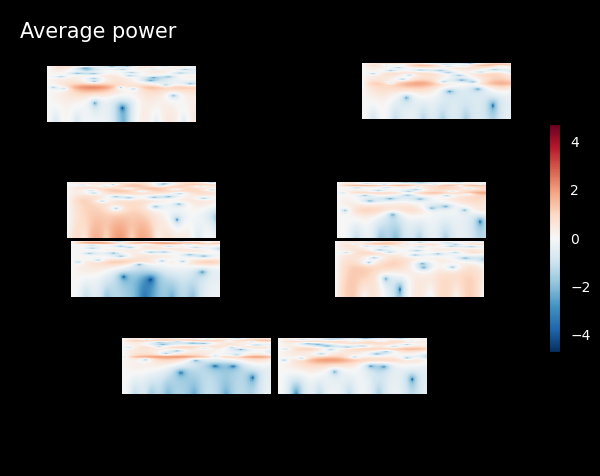

No baseline correction applied
No baseline correction applied
No baseline correction applied


'\n\n# Example of evaluating continous EEG sample\nreref, raw  = csvToRaw("eyes_closed.csv", 8)\npower = reref.compute_psd()\npower.plot()\npower.plot_topomap()\nend_time = math.floor(len(reref.times) / reref.info[\'sfreq\'])\nevents = mne.make_fixed_length_events(reref, start=1, stop=end_time, duration=end_time-1)\n# events = [[256, 0, 1]]\nprint("events: ", events)\nepochs = mne.Epochs(reref, events, tmin=0, tmax=8, event_id={"closed": 1}, baseline=(0,0))\nepochs.plot()\nvisualizePower(1, 35, epochs, True, True, "Eyes Closed")\n'

In [34]:
# Setting sensor location and Power Spectrum

'''
# Eyes Open
reref, raw = csvToRaw("eyes_open.csv", 8)
# Equally Spaced Events
events = mne.make_fixed_length_events(reref, start=1, stop=10, duration=1.)
event_dict = {'open': 1}
epochs = getEpochs(reref, events, event_dict)
# reref.plot()
# raw.plot()
#epochs = epochs[1,2,3,5,6,7]
#visualizeSpectrum(event_dict, "eyes open", epochs)
visualizePower(1, 35, epochs, False, True, "Eyes Open")

########################################


# Eyes Closed
reref, raw  = csvToRaw("eyes_closed.csv", 8)
# Equally Spaced Events
events = mne.make_fixed_length_events(reref, start=1, stop=10, duration=1.)
event_dict = {'closed': 1}
epochs = getEpochs(reref, events, event_dict)
epochs = epochs[1,2,3,5,6,7]
#visualizeSpectrum(event_dict, "eyes closed", epochs)
#visualizePower(1, 4, epochs)
visualizePower(1, 35, epochs, False, True, "Eyes Closed")
'''

#####
# events = mne.make_fixed_length_events(reref, start=1, stop=end_time, duration=end_time-1)
plotContinuousSpectorgram("eyes_closed.csv", [[512, 0, 1]], {"closed": 1},  length=1)

'''

# Example of evaluating continous EEG sample
reref, raw  = csvToRaw("eyes_closed.csv", 8)
power = reref.compute_psd()
power.plot()
power.plot_topomap()
end_time = math.floor(len(reref.times) / reref.info['sfreq'])
events = mne.make_fixed_length_events(reref, start=1, stop=end_time, duration=end_time-1)
# events = [[256, 0, 1]]
print("events: ", events)
epochs = mne.Epochs(reref, events, tmin=0, tmax=8, event_id={"closed": 1}, baseline=(0,0))
epochs.plot()
visualizePower(1, 35, epochs, True, True, "Eyes Closed")
'''






#print(psd)
#end_time = math.floor(len(reref.times) / reref.info['sfreq'])
#print("time ", end_time)
#events = mne.make_fixed_length_events(reref, start=0, stop=end_time, duration=end_time)
#print(events)
# epochs = mne.Epochs(raw, events, {'start':1}, 0, end_time)
#event_dict = {'closed': 1}
#epochs = mne.Epochs(raw, [[0, 0, 1]], tmin=0, tmax=5, event_id=event_dict, baseline=(0,0))

#epochs.plot()
#print(epochs)





# epochs.plot()
# spectrum = epochs.compute_psd()
# spectrum.plot_topomap()``
# mne.viz.plot_epochs(epochs, scalings='auto', title="Open")
# fig = raw.plot_sensors(show_names=True)
# spectrum = raw.compute_psd()
# spectrum.plot(average=True)
# spectrum.plot()
# spectrum.plot_topo(color='k', fig_facecolor='w', axis_facecolor='w')
# spectrum.plot_topomap(ch_type='eeg',vmin=16, vmax=26)
# mne.viz.plot_topomap(raw, raw.info, cmap='Spectral_r',sensors = True,vmin=16, vmax=26)